# RKHS-SHAP: Effect of Number of Features

This notebook demonstrates exact RKHS-SHAP versus Kernel SHAP on the Communities and Crime dataset with varying numbers of features.

## Overview
- **Dataset**: Communities and Crime (125 features)
- **Feature counts**: 10, 20, 50, 101 (fixed sample size: 100)
- **Model**: ExactGPModel with RBF kernel
- **Analysis**: Kernel SHAP vs Interventional RKHS-SHAP

In [1]:
import pickle
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from rkhs_shap.exact_gp import ExactGPModel
from rkhs_shap.rkhs_shap_exact import RKHSSHAP
from rkhs_shap.utils import calculate_additivity_mae, calculate_correlation, to_tensor

plt.style.use("default")
sns.set_palette("husl")
%matplotlib inline

warnings.filterwarnings("ignore")

LOAD_RESULTS_ONLY = False

SAMPLE_SIZE = 100
N_FEATURES_LIST = [10, 20, 50, 101]
VAL_SAMPLE_SIZE = 500
BACKGROUND_SIZE = 100
RANDOM_STATE = 42

RESULTS_DIR = Path("./n_features_results")
RESULTS_DIR.mkdir(exist_ok=True)
METRICS_CSV = RESULTS_DIR / "metrics.csv"
KERNEL_SHAP_FILE = RESULTS_DIR / "kernel_shap_explanations.pkl"
RKHS_SHAP_FILE = RESULTS_DIR / "rkhs_shap_explanations.pkl"

print(f"Feature counts to analyze: {N_FEATURES_LIST}")
print(f"Sample size: {SAMPLE_SIZE}")
print(f"Results directory: {RESULTS_DIR}")

Feature counts to analyze: [10, 20, 50, 101]
Sample size: 100
Results directory: n_features_results


In [2]:
def load_scaled_dataset(
    n_features: int, n_train: int, n_val: int = VAL_SAMPLE_SIZE
) -> tuple:
    """Load and scale Communities and Crime dataset."""
    X, y = shap.datasets.communitiesandcrime()
    X = X.iloc[:, :n_features]
    feature_names = X.columns.tolist()

    rng = np.random.default_rng(RANDOM_STATE)
    n_indices = n_train + n_val
    both_indices = rng.choice(len(X), size=n_indices, replace=False)
    train_indices = both_indices[:n_train]
    val_indices = both_indices[n_train:]

    X_train = X.iloc[train_indices].values
    y_train = y[train_indices]
    X_val = X.iloc[val_indices].values
    y_val = y[val_indices]

    feature_scaler = MinMaxScaler()
    X_train = feature_scaler.fit_transform(X_train)
    X_val = feature_scaler.transform(X_val)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val = target_scaler.transform(y_val.reshape(-1, 1)).flatten()

    return X_train, y_train, X_val, y_val, feature_names


X_full, y_full = shap.datasets.communitiesandcrime()
print(f"Full dataset shape: {X_full.shape}")
print(f"Target range: [{y_full.min():.3f}, {y_full.max():.3f}]")
print(f"First 10 feature names: {list(X_full.columns[:10])}")

Full dataset shape: (1994, 101)
Target range: [0.000, 4877.060]
First 10 feature names: ['population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up']


In [ ]:
def train_gp_model(
    X_train: np.ndarray, y_train: np.ndarray, training_iter: int = 50
) -> ExactGPModel:
    """Train GP model."""
    train_x = to_tensor(X_train)
    train_y = to_tensor(y_train)
    model = ExactGPModel(train_x, train_y)
    model.fit(training_iter=training_iter, lr=0.1)
    return model


def run_kernel_shap(
    model: ExactGPModel,
    X_background: np.ndarray,
    X_explain: np.ndarray,
    feature_names: list,
) -> tuple:
    """Run Kernel SHAP on the GP model."""
    start_time = time.time()
    explainer = shap.KernelExplainer(
        model=model.predict_mean_numpy,
        data=X_background,
        feature_names=feature_names,
        algorithm="permutation",
    )
    explanation = explainer(X_explain)
    shap_time = time.time() - start_time
    return explanation, shap_time


def run_rkhs_shap(
    model: ExactGPModel,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_explain: np.ndarray,
) -> tuple:
    """Run exact RKHS-SHAP (Interventional) on the GP model."""
    start_time = time.time()

    train_x = to_tensor(X_train)
    train_y = to_tensor(y_train)
    noise_var = model.likelihood.noise.detach().cpu().float()

    rkhs_shap = RKHSSHAP(
        X=train_x,
        y=train_y,
        kernel=model.covar_module,
        noise_var=noise_var,
        cme_reg=1e-4,
    )

    X_explain_tensor = to_tensor(X_explain)
    n_features = X_explain.shape[1]

    m = X_train.shape[0]
    num_samples = 2 * m + 2**11  # same as Kernel SHAP "auto" setting
    shap_values = rkhs_shap.fit(
        X_test=X_explain_tensor,
        method="I",
        sample_method="full" if n_features <= 11 else "MC",
        num_samples=num_samples,
    )

    shap_time = time.time() - start_time
    return shap_values, shap_time


def compute_accuracy_metrics(
    kernel_shap: shap.Explanation,
    rkhs_shap: np.ndarray,
    model_predictions: np.ndarray,
    baseline: float,
) -> dict:
    """Compare RKHS-SHAP and Kernel SHAP accuracy."""
    kernel_values = kernel_shap.values

    kernel_additivity_errors = calculate_additivity_mae(
        kernel_values, to_tensor(model_predictions), baseline
    )
    rkhs_additivity_errors = calculate_additivity_mae(
        rkhs_shap, to_tensor(model_predictions), baseline
    )

    correlation = calculate_correlation(kernel_values, rkhs_shap)
    mse = np.mean((kernel_values - rkhs_shap) ** 2)

    return {
        "kernel_additivity_mae": kernel_additivity_errors,
        "rkhs_additivity_mae": rkhs_additivity_errors,
        "methods_correlation": correlation,
        "methods_mse": mse,
    }

In [4]:
all_metrics = []
all_kernel_explanations = []
all_rkhs_explanations = []
rng = np.random.default_rng(RANDOM_STATE)

if not LOAD_RESULTS_ONLY:
    for n_features in N_FEATURES_LIST:
        print(f"\n{'=' * 70}")
        print(f"Analyzing {n_features} features")
        print(f"{'=' * 70}")

        X_train, y_train, X_val, y_val, feature_names = load_scaled_dataset(
            n_features, SAMPLE_SIZE
        )

        print(f"Training set shape: {X_train.shape}")
        print(f"Validation set shape: {X_val.shape}")
        print(
            f"y_train range: [{y_train.min():.4f}, {y_train.max():.4f}], "
            f"mean: {y_train.mean():.4f}"
        )

        print("Training GP model...")
        start_time = time.time()
        model = train_gp_model(X_train, y_train)
        training_time = time.time() - start_time
        print(f"Training time: {training_time:.2f}s")

        y_pred = model.predict_mean_numpy(X_val)
        r2 = r2_score(y_val, y_pred)
        print(f"Model R² on validation set: {r2:.4f}")

        X_explain = X_train
        print(f"Explaining {X_explain.shape[0]} points")

        print("Running Kernel SHAP...")
        background_indices = rng.choice(
            len(X_train), size=min(BACKGROUND_SIZE, len(X_train)), replace=False
        )
        X_background = X_train[background_indices]
        kernel_explanation, kernel_shap_time = run_kernel_shap(
            model, X_background, X_explain, feature_names
        )
        print(f"Kernel SHAP time: {kernel_shap_time:.2f}s")
        all_kernel_explanations.append(kernel_explanation)

        print("Running RKHS-SHAP...")
        rkhs_shap_values, rkhs_shap_time = run_rkhs_shap(
            model, X_train, y_train, X_explain
        )
        print(f"RKHS-SHAP time: {rkhs_shap_time:.2f}s")
        all_rkhs_explanations.append(rkhs_shap_values)

        pred_explain = model.predict_mean_numpy(X_explain)
        baseline = model.predict_mean_numpy(X_train).mean()
        accuracy_metrics = compute_accuracy_metrics(
            kernel_explanation, rkhs_shap_values, pred_explain, baseline
        )

        print(f"Methods correlation: {accuracy_metrics['methods_correlation']:.3f}")
        print(f"Kernel additivity MAE: {accuracy_metrics['kernel_additivity_mae']:.4f}")
        print(f"RKHS additivity MAE: {accuracy_metrics['rkhs_additivity_mae']:.4f}")

        metrics = {
            "n_features": n_features,
            "sample_size": len(X_train),
            "training_time": training_time,
            "model_r2": r2,
            "kernel_shap_time": kernel_shap_time,
            "rkhs_shap_time": rkhs_shap_time,
            **accuracy_metrics,
        }
        all_metrics.append(metrics)

    print(f"\n{'=' * 70}")
    print("Analysis complete!")
    print(f"{'=' * 70}")


Analyzing 10 features
Training set shape: (100, 10)
Validation set shape: (500, 10)
y_train range: [-1.0452, 3.7594], mean: 0.0000
Training GP model...
iter 1/50 - loss: 1.196 {} noise: 0.693
iter 10/50 - loss: 1.098 {} noise: 0.365
iter 20/50 - loss: 1.072 {} noise: 0.359
iter 30/50 - loss: 1.022 {} noise: 0.294
iter 40/50 - loss: 0.963 {} noise: 0.175
iter 50/50 - loss: 0.961 {} noise: 0.142
Training time: 0.68s
Model R² on validation set: 0.2141
Explaining 100 points
Running Kernel SHAP...


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel SHAP time: 4.93s
Running RKHS-SHAP...


100%|██████████| 1024/1024 [00:00<00:00, 1072.18it/s]


Additivity MAE: 0.000000
RKHS-SHAP time: 0.96s
Methods correlation: 0.984
Kernel additivity MAE: 0.0000
RKHS additivity MAE: 0.0275

Analyzing 20 features
Training set shape: (100, 20)
Validation set shape: (500, 20)
y_train range: [-1.0452, 3.7594], mean: 0.0000
Training GP model...
iter 1/50 - loss: 1.254 {} noise: 0.693
iter 10/50 - loss: 1.111 {} noise: 0.354
iter 20/50 - loss: 1.042 {} noise: 0.270
iter 30/50 - loss: 0.953 {} noise: 0.187
iter 40/50 - loss: 0.922 {} noise: 0.099
iter 50/50 - loss: 0.903 {} noise: 0.111
Training time: 0.08s
Model R² on validation set: 0.2609
Explaining 100 points
Running Kernel SHAP...


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel SHAP time: 10.55s
Running RKHS-SHAP...


100%|██████████| 2250/2250 [00:02<00:00, 1012.66it/s]


Additivity MAE: 0.000002
RKHS-SHAP time: 2.24s
Methods correlation: 0.973
Kernel additivity MAE: 0.0000
RKHS additivity MAE: 0.0242

Analyzing 50 features
Training set shape: (100, 50)
Validation set shape: (500, 50)
y_train range: [-1.0452, 3.7594], mean: 0.0000
Training GP model...
iter 1/50 - loss: 1.359 {} noise: 0.693
iter 10/50 - loss: 1.069 {} noise: 0.340
iter 20/50 - loss: 0.892 {} noise: 0.148
iter 30/50 - loss: 0.861 {} noise: 0.093
iter 40/50 - loss: 0.837 {} noise: 0.094
iter 50/50 - loss: 0.825 {} noise: 0.095
Training time: 0.08s
Model R² on validation set: 0.4827
Explaining 100 points
Running Kernel SHAP...


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel SHAP time: 13.40s
Running RKHS-SHAP...


100%|██████████| 2250/2250 [00:02<00:00, 956.38it/s]


Additivity MAE: 0.000000
RKHS-SHAP time: 2.38s
Methods correlation: 0.976
Kernel additivity MAE: 0.0000
RKHS additivity MAE: 0.0232

Analyzing 101 features
Training set shape: (100, 101)
Validation set shape: (500, 101)
y_train range: [-1.0452, 3.7594], mean: 0.0000
Training GP model...
iter 1/50 - loss: 1.447 {} noise: 0.693
iter 10/50 - loss: 1.210 {} noise: 0.340
iter 20/50 - loss: 0.948 {} noise: 0.138
iter 30/50 - loss: 0.849 {} noise: 0.069
iter 40/50 - loss: 0.795 {} noise: 0.057
iter 50/50 - loss: 0.763 {} noise: 0.049
Training time: 0.09s
Model R² on validation set: 0.4414
Explaining 100 points
Running Kernel SHAP...


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel SHAP time: 19.60s
Running RKHS-SHAP...


100%|██████████| 2250/2250 [00:02<00:00, 864.08it/s]

Additivity MAE: 0.000000
RKHS-SHAP time: 2.64s
Methods correlation: 0.913
Kernel additivity MAE: 0.0000
RKHS additivity MAE: 0.0135

Analysis complete!


In [9]:
if LOAD_RESULTS_ONLY:
    metrics_df = pd.read_csv(METRICS_CSV)
    print(f"Loaded metrics: {metrics_df.shape}")

    with open(KERNEL_SHAP_FILE, "rb") as f:
        all_kernel_explanations = pickle.load(f)
    print(f"Loaded Kernel SHAP explanations: {len(all_kernel_explanations)}")

    with open(RKHS_SHAP_FILE, "rb") as f:
        all_rkhs_explanations = pickle.load(f)
    print(f"Loaded RKHS-SHAP explanations: {len(all_rkhs_explanations)}")
else:
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df.to_csv(METRICS_CSV, index=False)
    print(f"Saved metrics to: {METRICS_CSV}")

    with open(KERNEL_SHAP_FILE, "wb") as f:
        pickle.dump(all_kernel_explanations, f)
    print(f"Saved Kernel SHAP explanations to: {KERNEL_SHAP_FILE}")

    with open(RKHS_SHAP_FILE, "wb") as f:
        pickle.dump(all_rkhs_explanations, f)
    print(f"Saved RKHS-SHAP explanations to: {RKHS_SHAP_FILE}")

print(f"\nFeature counts analyzed: {sorted(metrics_df['n_features'].unique())}")

Saved metrics to: n_features_results/metrics.csv
Saved Kernel SHAP explanations to: n_features_results/kernel_shap_explanations.pkl
Saved RKHS-SHAP explanations to: n_features_results/rkhs_shap_explanations.pkl

Feature counts analyzed: [np.int64(10), np.int64(20), np.int64(50), np.int64(101)]


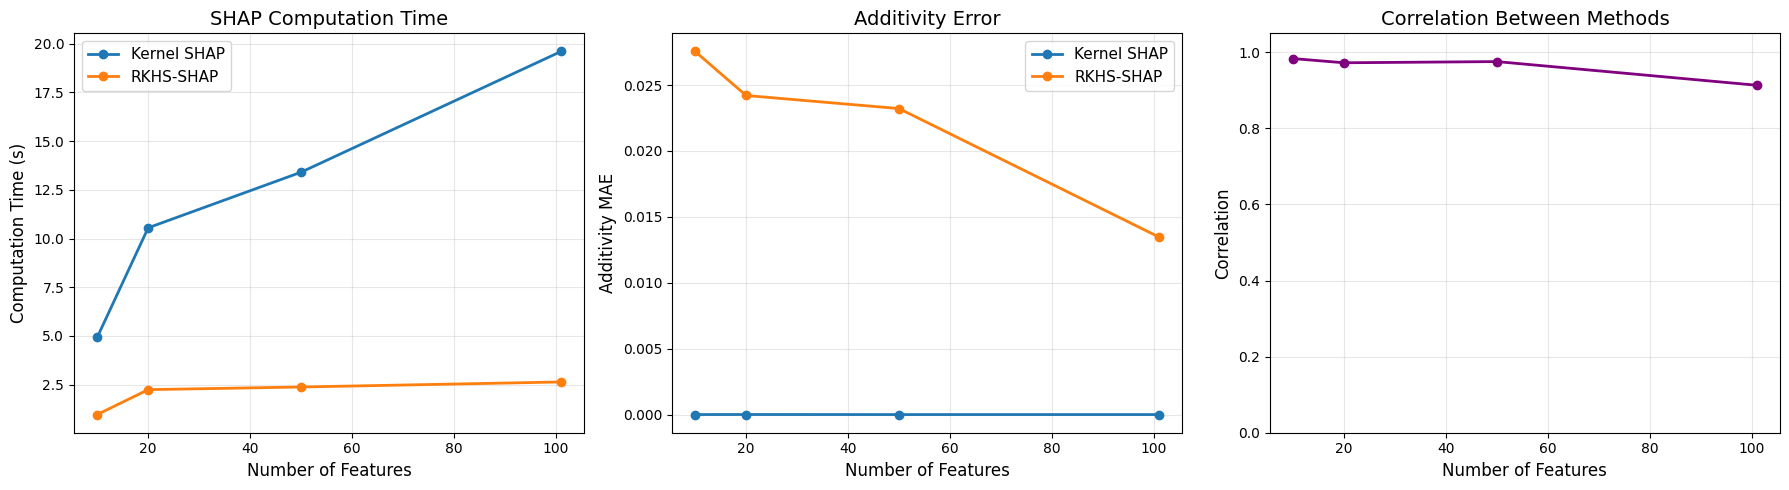


Metrics Summary:
 n_features  sample_size  training_time  model_r2  kernel_shap_time  rkhs_shap_time  kernel_additivity_mae  rkhs_additivity_mae  methods_correlation  methods_mse
         10          100       0.679368  0.214131          4.927137        0.962257           2.660953e-06             0.027543             0.983623     0.001402
         20          100       0.080405  0.260943         10.550311        2.241564           5.386472e-06             0.024205             0.972591     0.001260
         50          100       0.076713  0.482750         13.404598        2.377240           9.919330e-07             0.023212             0.975724     0.000677
        101          100       0.088472  0.441404         19.602024        2.636071           1.269099e-06             0.013470             0.913485     0.000383


In [10]:
kernel_color = "#1f77b4"
rkhs_color = "#ff7f0e"

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(
    metrics_df["n_features"],
    metrics_df["kernel_shap_time"],
    marker="o",
    label="Kernel SHAP",
    color=kernel_color,
    linewidth=2,
)
axs[0].plot(
    metrics_df["n_features"],
    metrics_df["rkhs_shap_time"],
    marker="o",
    label="RKHS-SHAP",
    color=rkhs_color,
    linewidth=2,
)
axs[0].set_xlabel("Number of Features", fontsize=12)
axs[0].set_ylabel("Computation Time (s)", fontsize=12)
axs[0].set_title("SHAP Computation Time", fontsize=14)
axs[0].legend(fontsize=11)
axs[0].grid(True, alpha=0.3)

axs[1].plot(
    metrics_df["n_features"],
    metrics_df["kernel_additivity_mae"],
    marker="o",
    label="Kernel SHAP",
    color=kernel_color,
    linewidth=2,
)
axs[1].plot(
    metrics_df["n_features"],
    metrics_df["rkhs_additivity_mae"],
    marker="o",
    label="RKHS-SHAP",
    color=rkhs_color,
    linewidth=2,
)
axs[1].set_xlabel("Number of Features", fontsize=12)
axs[1].set_ylabel("Additivity MAE", fontsize=12)
axs[1].set_title("Additivity Error", fontsize=14)
axs[1].legend(fontsize=11)
axs[1].grid(True, alpha=0.3)

axs[2].plot(
    metrics_df["n_features"],
    metrics_df["methods_correlation"],
    marker="o",
    color="purple",
    linewidth=2,
)
axs[2].set_xlabel("Number of Features", fontsize=12)
axs[2].set_ylabel("Correlation", fontsize=12)
axs[2].set_title("Correlation Between Methods", fontsize=14)
axs[2].set_ylim(0, 1.05)
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))

## SHAP Value Comparison for Each Feature Count

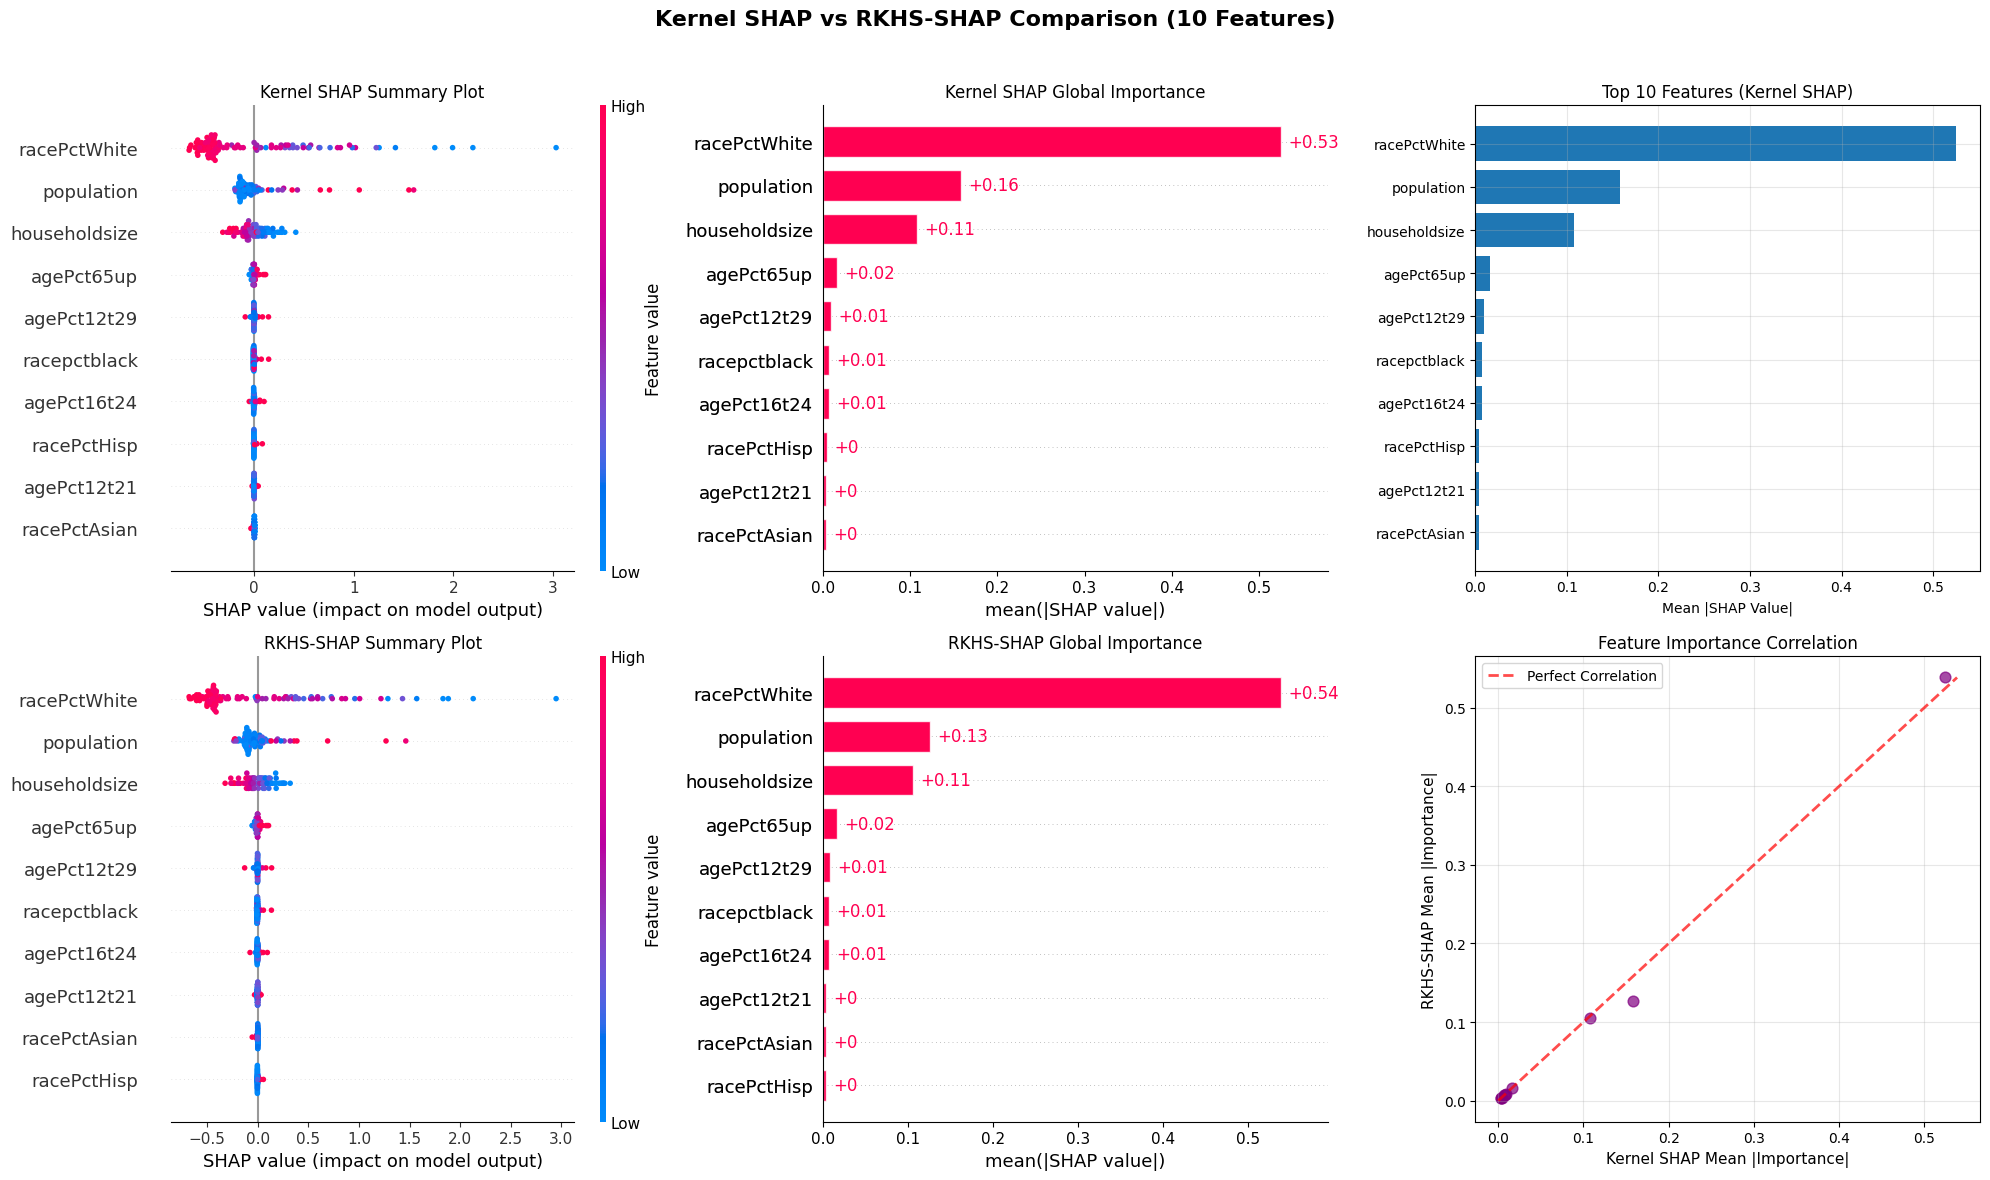

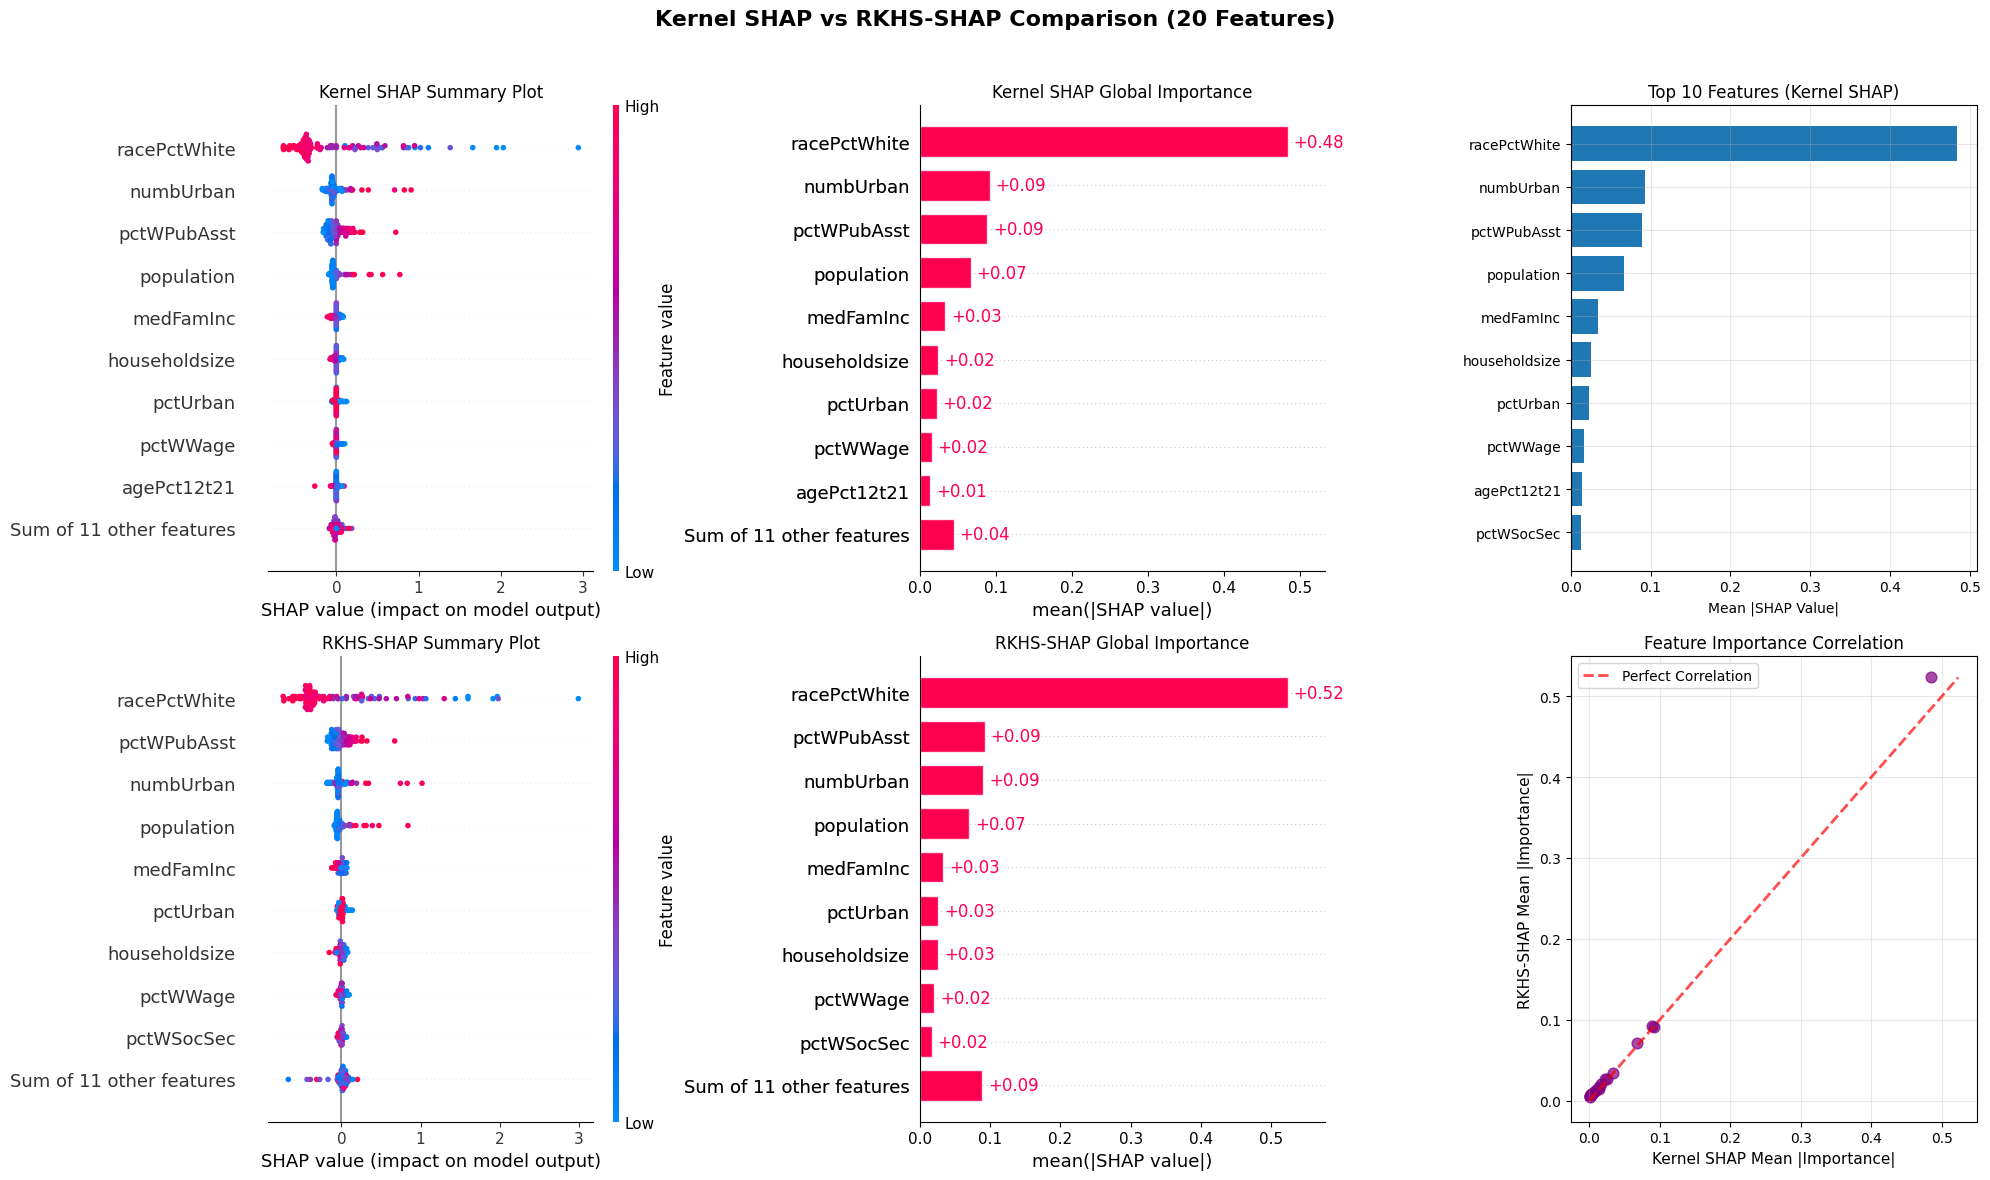

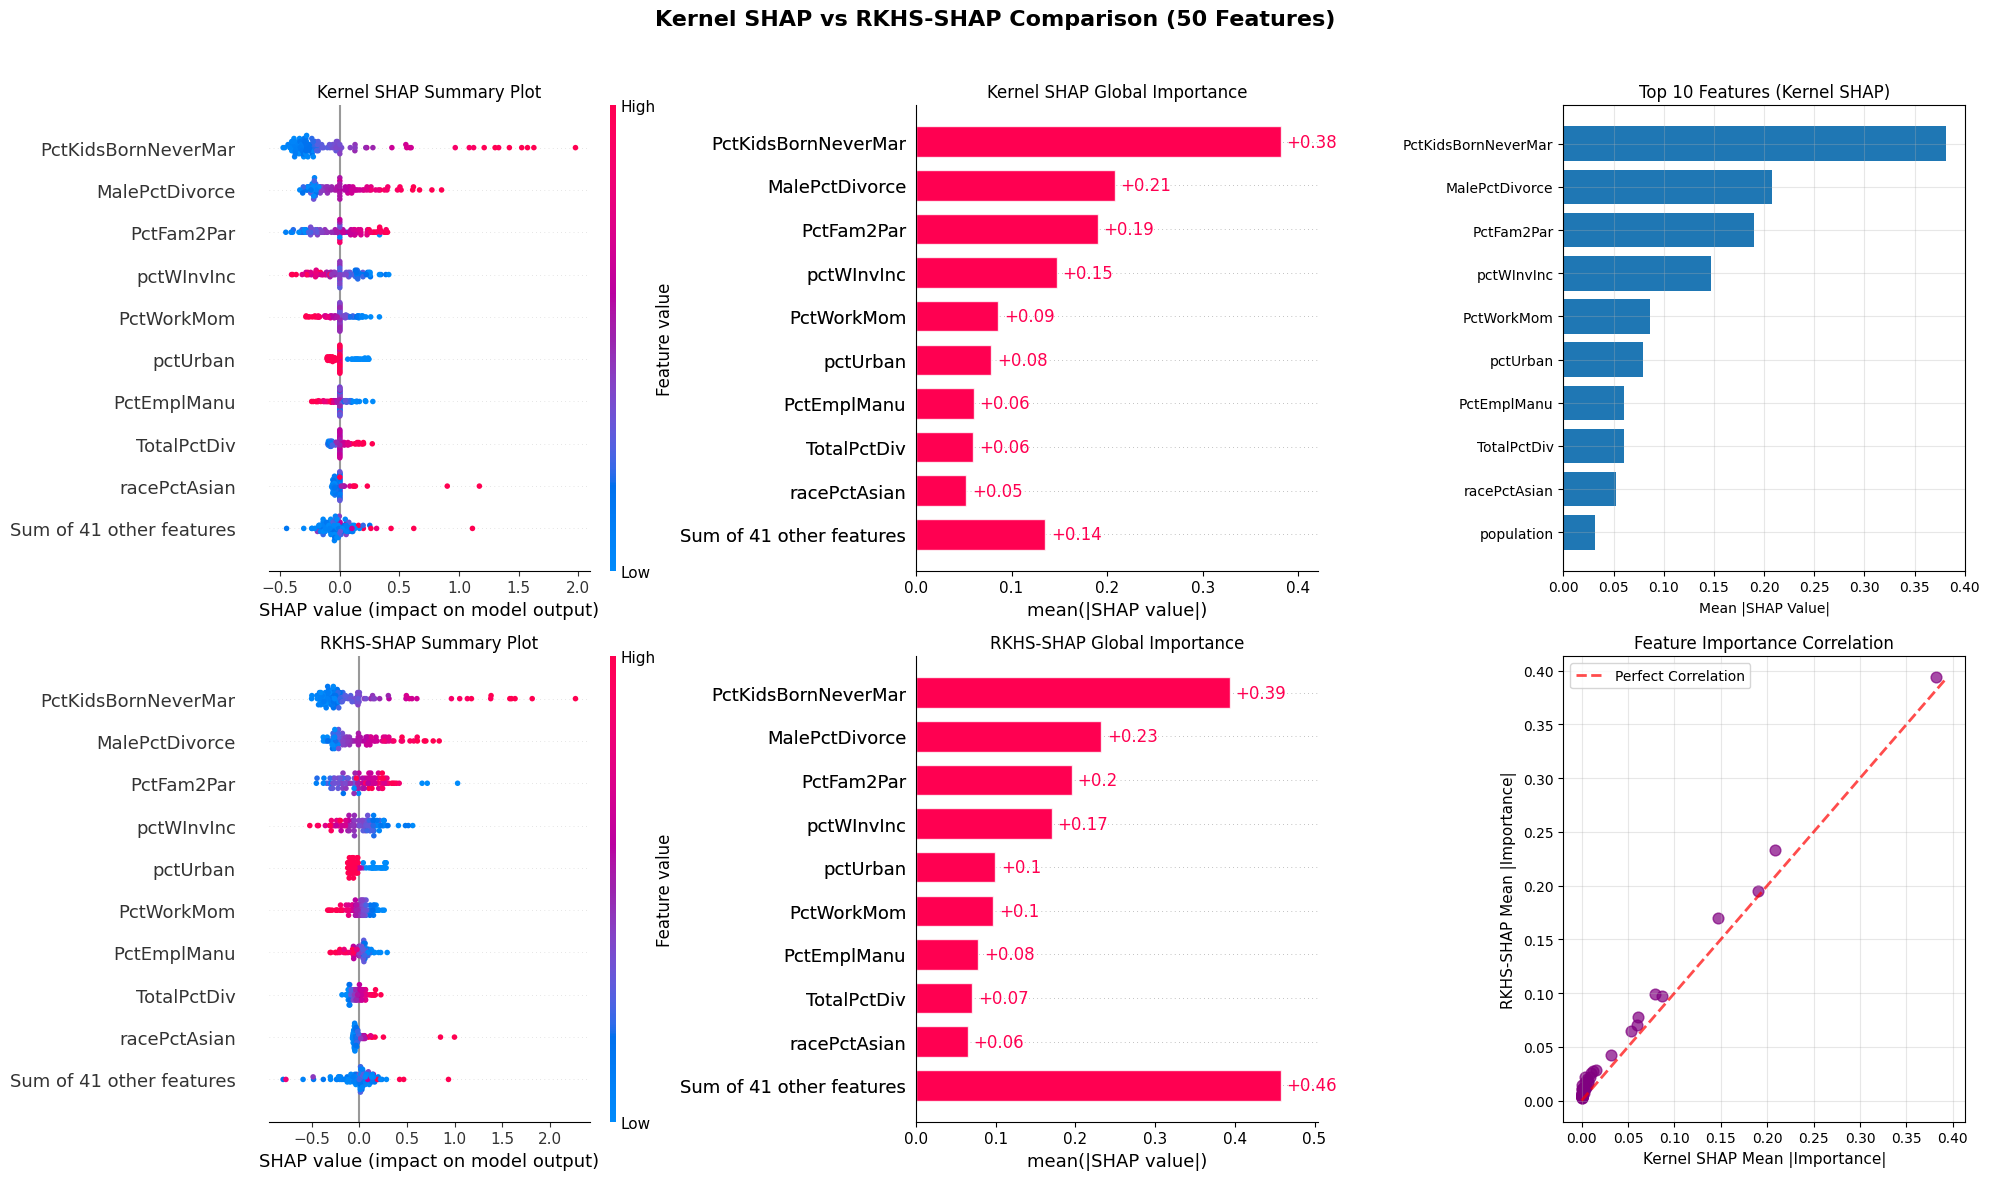

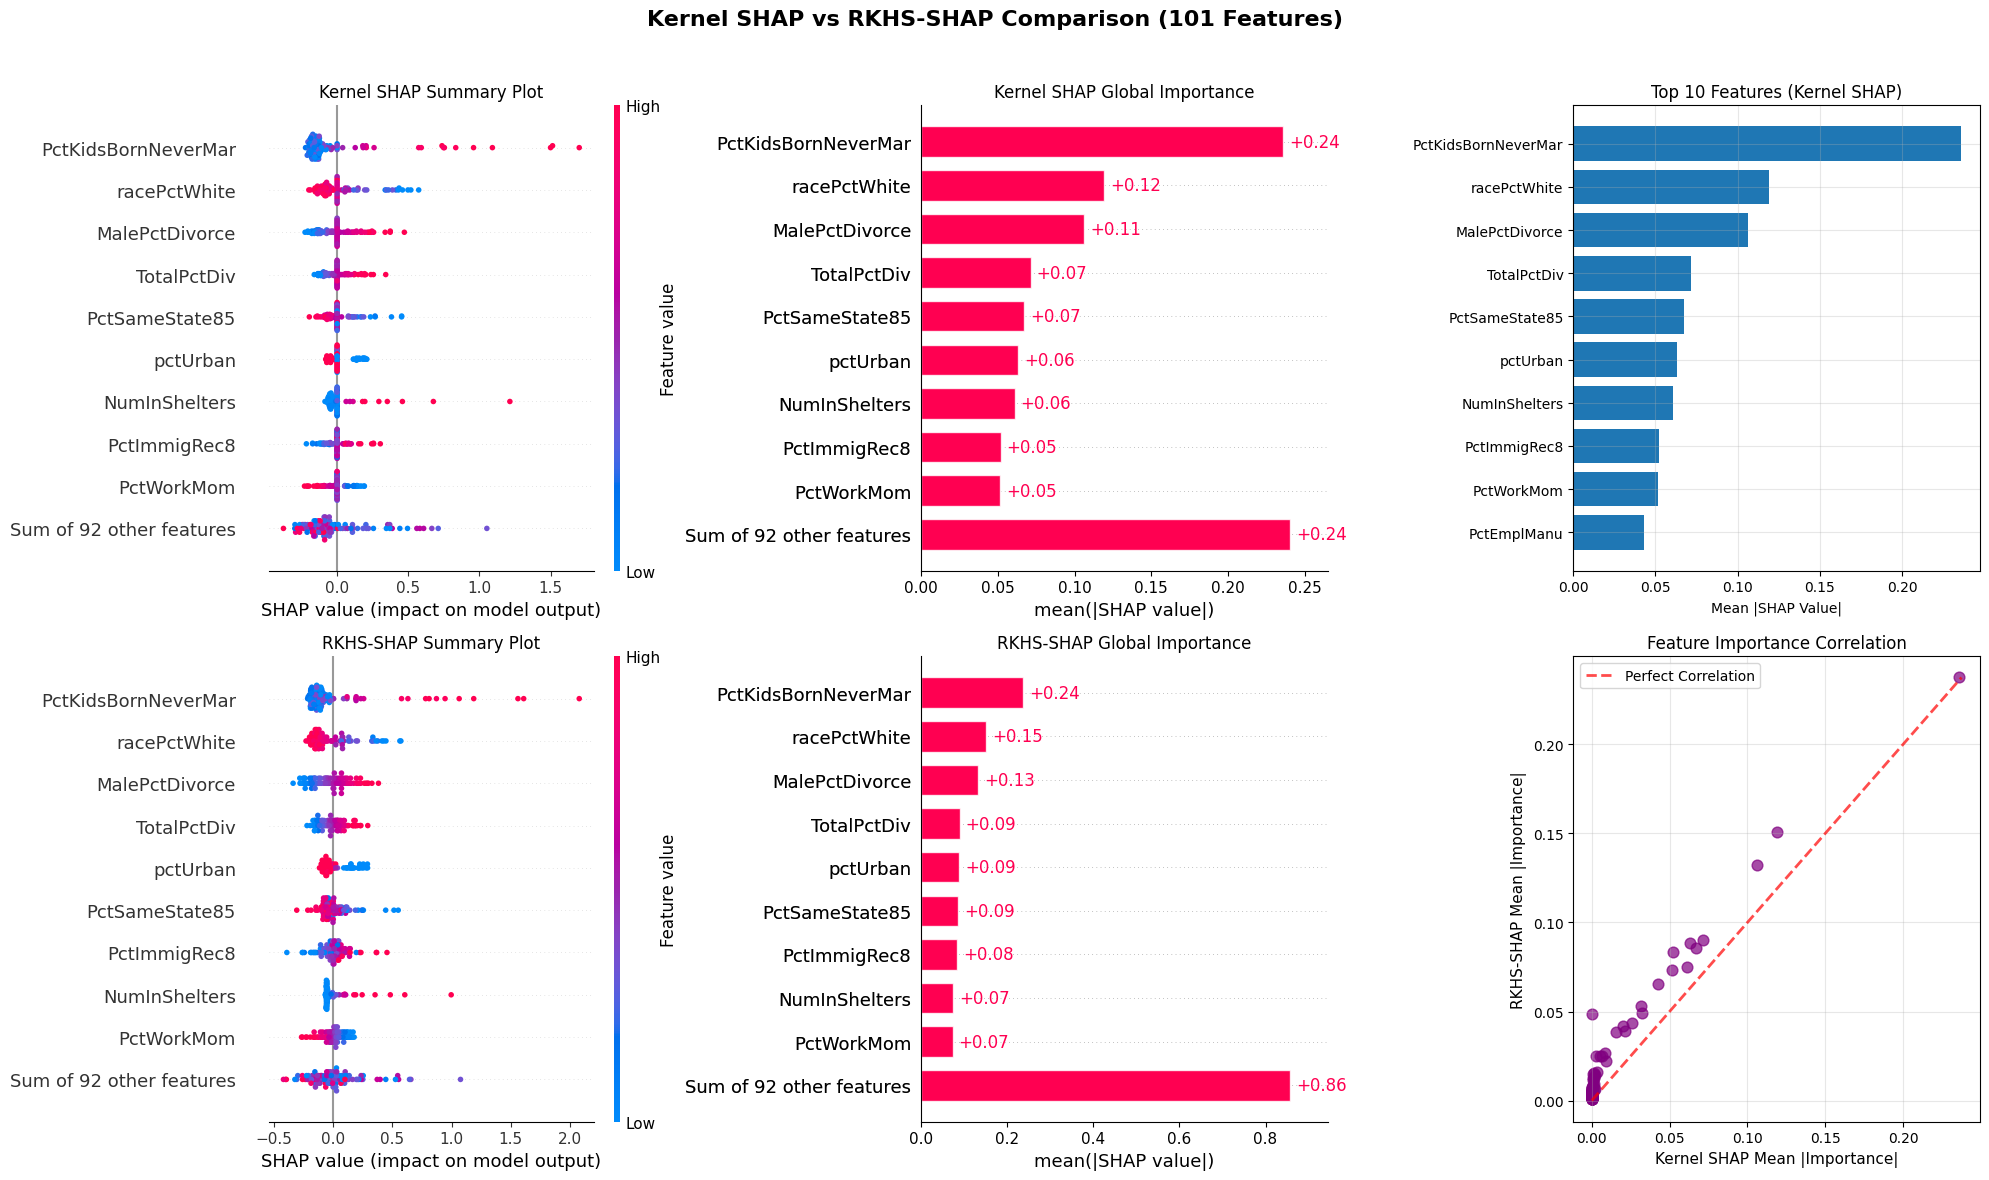

In [11]:
feature_counts = sorted(metrics_df["n_features"].unique())

for i, n_features in enumerate(feature_counts):
    kernel_explanation = all_kernel_explanations[i]
    rkhs_explanation = all_rkhs_explanations[i]

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(
        f"Kernel SHAP vs RKHS-SHAP Comparison ({n_features} Features)",
        fontsize=16,
        fontweight="bold",
    )

    shap.plots.beeswarm(kernel_explanation, ax=axes[0, 0], plot_size=None, show=False)
    axes[0, 0].set_title("Kernel SHAP Summary Plot", fontsize=12)

    shap.plots.bar(kernel_explanation, ax=axes[0, 1], show=False)
    axes[0, 1].set_title("Kernel SHAP Global Importance", fontsize=12)

    kernel_mean_abs = np.mean(np.abs(kernel_explanation.values), axis=0)
    rkhs_mean_abs = np.mean(np.abs(rkhs_explanation), axis=0)

    sorted_indices = np.argsort(kernel_mean_abs)[-10:]
    axes[0, 2].barh(
        range(len(sorted_indices)),
        kernel_mean_abs[sorted_indices],
        color=kernel_color,
    )
    axes[0, 2].set_yticks(range(len(sorted_indices)))
    axes[0, 2].set_yticklabels(
        np.array(kernel_explanation.feature_names)[sorted_indices]
    )
    axes[0, 2].set_xlabel("Mean |SHAP Value|")
    axes[0, 2].set_title("Top 10 Features (Kernel SHAP)", fontsize=12)
    axes[0, 2].grid(True, alpha=0.3)

    rkhs_fake_explanation = shap.Explanation(
        values=rkhs_explanation,
        data=kernel_explanation.data,
        feature_names=kernel_explanation.feature_names,
    )

    shap.plots.beeswarm(
        rkhs_fake_explanation, ax=axes[1, 0], plot_size=None, show=False
    )
    axes[1, 0].set_title("RKHS-SHAP Summary Plot", fontsize=12)

    shap.plots.bar(rkhs_fake_explanation, ax=axes[1, 1], show=False)
    axes[1, 1].set_title("RKHS-SHAP Global Importance", fontsize=12)

    axes[1, 2].scatter(kernel_mean_abs, rkhs_mean_abs, alpha=0.7, s=60, color="purple")

    max_val = max(kernel_mean_abs.max(), rkhs_mean_abs.max())
    axes[1, 2].plot(
        [0, max_val],
        [0, max_val],
        "r--",
        alpha=0.7,
        label="Perfect Correlation",
        linewidth=2,
    )

    axes[1, 2].set_xlabel("Kernel SHAP Mean |Importance|", fontsize=11)
    axes[1, 2].set_ylabel("RKHS-SHAP Mean |Importance|", fontsize=11)
    axes[1, 2].set_title("Feature Importance Correlation", fontsize=12)
    axes[1, 2].legend(fontsize=10)
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()